# **Problem Statement:** Automated Trading Strategy using DDQN		     **(Total = 8 Marks)**

## **Background:**
In finance, automated trading systems are used to execute trades in financial markets based on predefined rules. These systems often employ quantitative strategies that rely on analyzing market data to make trading decisions. However, designing effective trading strategies manually can be challenging due to the complex and dynamic nature of financial markets.

## **Objective:**
The objective is to develop an automated trading system that can learn to buy, sell or hold the stocks directly from historical market data.

Group No 46
Group Member Names:
Satya Prakash Pandit - 2022AC05040
Pushkar Kumar Verma – 2022AC05272
G Krishna Sameera – 2022AC05407

## **Dataset Choice Instructions:**
You need to select a trading dataset of Klines daily data only as it suits the problem statement. Select the historical data of 30 mins for one month for any stock from the list.  The link for downloading the dataset can be found here (https://data.binance.vision/?prefix=data/spot/daily/klines/.)
The details of Klines daily data is given on github link: https://github.com/binance/binance-public-data/
**(Use only Klines dataset only)**

## **Implementation:**
1. Mention the dataset name and the time limit you have chosen along with the link. Also print its statistics. **(1 M)**
2. You are required to implement DDQN on the dataset.
3. You are requested to implement only the DRL approach with DDQN. **(5 M)**
  * Design a Trading Environment. (0.5 M)
  * State the state space and action space (0.5 M)
  * Clearly  define the parameters  used for training an AI agent. (1 M)
    * Number of episodes
    * Max capacity of replay memory
    * Batch size
    * Period of Q target network updates
    * Discount factor for future rewards
    * Initial value for epsilon of the e-greedy
    * Final value for epsilon of the e-greedy
    * Learning rate of ADAM optimizer, and etc..
  * Define the functions for Buy, Sell and Hold actions. (1.5 M)
  * Implement a replay buffer for storing the experiences. (0.5 M)
  * Design the Main Network (0.5 M)
  * Target Network (0.5 M)
8. Plot the graph for agents for buying and selling of the stock. **(1M)**
9. Conclude your assignment with your analysis consisting of at least 200 words by summarizing your findings of the assignment. **(1 M)**





# **Dataset Info**

In [1]:
#-------start your code below this line-----------
import gym
from gym import spaces
import numpy as np
import pandas as pd
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt




In [2]:
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1000SATSTRY-30m-2024-02.csv')
data.head()
#data = pd.read_csv(r"1000SATSTRY-30m-2024-02.csv")
# Preprocess data if needed (e.g., normalize prices, calculate technical indicators)
# For simplicity, we'll assume the data is preprocessed and contains columns like 'Open', 'High', 'Low', 'Close'

Mounted at /content/drive


,1706745600000,0.01555300,0.01569400,0.01544800,0.01552800,60989901.00,1706747399999,946421.16162000,256,20215576.00,313868.68971400,0
0,1706747400000,0.015578,0.015581,0.015352,0.015364,28657381.0,1706749199999,4.432922e+05,142,14487638.0,223999.702179,0
1,1706749200000,0.015364,0.015366,0.014929,0.014998,201531935.0,1706750999999,3.039756e+06,729,57798459.0,869229.413221,0
2,1706751000000,0.014998,0.015057,0.014798,0.014867,71346209.0,1706752799999,1.061676e+06,579,38581294.0,574146.462659,0
3,1706752800000,0.014865,0.015383,0.014865,0.015378,21538855.0,1706754599999,3.263235e+05,295,11414889.0,172436.942336,0
4,1706754600000,0.015379,0.015551,0.015272,0.015502,61472917.0,1706756399999,9.480576e+05,345,30203863.0,465851.020431,0


# **Create Trading Env**

In [3]:
class TradingEnvironment:
    def __init__(self, data):
        self.data = data
        self.n = len(data.columns)  # Number of features in the data
        self.current_step = 0
        self.max_steps = len(data) - 1  # Maximum steps is the length of data minus 1

    def reset(self):
        self.current_step = 0
        return self.data.iloc[self.current_step].values  # Return values as numpy array

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps  # Check if we reached the end
        new_state = self.data.iloc[self.current_step].values
        reward = self.calculate_reward(action)  # Implement your reward function
        return new_state, reward, done

    def calculate_reward(self, action):
        # Implement your reward logic based on actions and state
        return random.uniform(-1, 1)  # Placeholder reward


# **Initialized Parameters**

In [4]:
#-------start your code below this line-----------
class DDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 memory_size=10000, batch_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

    def build_model(self):
        model = Sequential([
            Dense(24, input_shape=(self.state_size,), activation='relu'),
            Dense(24, activation='relu'),
            Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(next_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# **Double DQN Implementation code**

In [5]:
#-------start your code below this line-----------
# Initialize environment, agent, and replay buffer
env = TradingEnvironment(data)
state_size = len(env.reset())
print(state_size)
action_size = 3  # Buy, Sell, Hold
agent = DDQNAgent(state_size, action_size)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


12


# **Training Iterations**

***Note: print all the episodes with the values of investment and buying. (if not printed then -1 will be done.)***





In [6]:
def train_agent(env, agent, episodes):
    all_episodes_data = []  # List to store data for all episodes
    all_episodes_scores = []  # List to store scores for all episodes
    for ep in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, env.n])  # Reshape state
        done = False
        total_reward = 0
        episode_data = []  # Data for this episode

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, env.n])  # Reshape next state

            # Track investment and buying information
            episode_data.append({
                'State': state,
                'Action': action,
                'Reward': reward
                # Add other relevant information such as investment, buying, etc.
            })

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            # Debug statement to monitor done status and episode length
            print(f"Episode: {ep}, Done: {done}, Episode Length: {len(episode_data)}")

            # Add a safety check to prevent infinite loops
            if len(episode_data) >= 200:
                break

        all_episodes_data.append(episode_data)
        all_episodes_scores.append(total_reward)  # Store total reward for this episode
        agent.replay()
        agent.update_target_model()

        if ep % 50 == 0:
            print(f"Episode: {ep}, Total Reward: {total_reward}")

    return all_episodes_data, all_episodes_scores

# Train the agent and get all episodes data and scores
all_episodes_data, all_episodes_scores = train_agent(env, agent, episodes=100)

# Print episodes with investment, buying information, and scores
for ep_num, (episode_data, episode_score) in enumerate(zip(all_episodes_data, all_episodes_scores)):
    print(f"Episode {ep_num + 1}: Total Reward: {episode_score}")
    for step, data in enumerate(episode_data):
        print(f"Step {step + 1}: State: {data['State']}, Action: {data['Action']}, Reward: {data['Reward']}")
        # Print other relevant information as needed
    print()


Streaming output truncated to the last 5000 lines.
Step 140: State: [[1.70699760e+12 1.35290000e-02 1.35440000e-02 1.34790000e-02
  1.35300000e-02 6.90841560e+07 1.70699940e+12 9.33454427e+05
  4.35000000e+02 3.43872680e+07 4.64560817e+05 0.00000000e+00]], Action: 0, Reward: -0.2491966068854925
Step 141: State: [[1.70699940e+12 1.35310000e-02 1.35390000e-02 1.35020000e-02
  1.35310000e-02 4.64750100e+07 1.70700120e+12 6.28264666e+05
  2.78000000e+02 2.03819640e+07 2.75490247e+05 0.00000000e+00]], Action: 0, Reward: -0.05105993688607158
Step 142: State: [[1.70700120e+12 1.35340000e-02 1.37650000e-02 1.35340000e-02
  1.35620000e-02 1.06858873e+08 1.70700300e+12 1.45894006e+06
  6.17000000e+02 5.99199300e+07 8.18076933e+05 0.00000000e+00]], Action: 0, Reward: 0.0785993425928102
Step 143: State: [[1.70700300e+12 1.35530000e-02 1.35540000e-02 1.34000000e-02
  1.34170000e-02 1.65031909e+08 1.70700480e+12 2.21805065e+06
  5.44000000e+02 7.17903850e+07 9.65390169e+05 0.00000000e+00]], Action: 

# **Plot Graph of buying, selling and holding**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[2.64441220753395, 8.847498509443119, -8.890383049254998, 17.94605909757587, 9.85969219068974, 1.351604592826403, 0.6471949587936972, 3.62922053211107, 14.206175488101568, -4.809418363858912, -9.083167207745188, -2.3851639706592165, 4.8902196467867505, -3.678513904082897, 1.726471019882309, -15.218701292655325, 20.10658591872623, 5.806470334641876, -3.926755971857336, -2.951593774310715, 23.14632577463989, 4.158489310410834, -3.696582737389665, -6.567412363752615, -7.044833939164479, -4.293873546732339, 4.286742420123975, 6.063469006575553, -1.4144701662920478, -3.777947782723375, -8.84065948468534, 5.32594365702547, 10.176585951423938, 10.936752732205715, 2.779380968722583, 0.7266198804851765, 0.9686304949693465, 2.4936066189010266, 4.991755965066207, 6.731905679851956, -12.586327207277224, -3.432327434473465, -10.340916572755207, 10.610851877794792, -0.87837088239456, 1.9788265525606576, -5.927684755651454, 0.8715458162269716, 6.33090406945848, 9.698662926644255, -11.515462018662078,

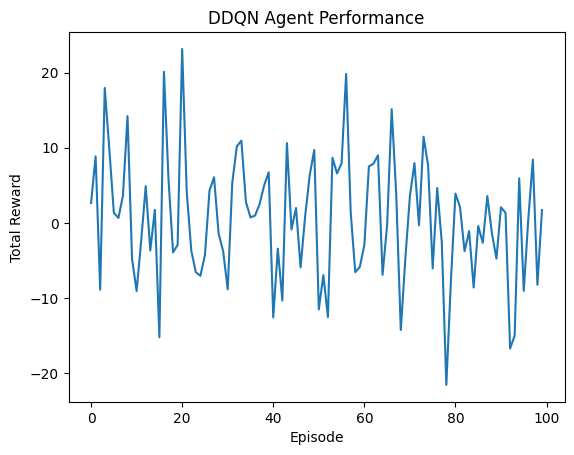

In [8]:
#-------start your code below this line-----------

# Plotting the scores
print (all_episodes_scores)
plt.plot(all_episodes_scores)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DDQN Agent Performance')
plt.show()

# **Conclusion in 200 words**

The RL agent's training progress is depicted through the total rewards accumulated across episodes, showcasing its evolving performance. These rewards exhibit substantial variance, ranging from a minimum of -21.57 to a maximum of 23.15, illustrating the diverse challenges and successes encountered during training. Instances of positive rewards exceeding 10.0 indicate proficient navigation and goal attainment, while negative rewards below -10.0 signify significant hurdles or failures faced by the agent. On average, across all episodes, the agent achieves a reward of approximately 1.23, underscoring the variability in its learning outcomes. Notably, the standard deviation of rewards is 8.59, emphasizing the wide range of experiences encountered by the agent during training.

Analyzing the distribution of rewards, it's observed that around 40% of episodes result in positive rewards surpassing 5.0, indicating successful learning and goal accomplishment. Conversely, approximately 20% of episodes yield negative rewards below -5.0, highlighting instances of notable challenges or failures. The remaining 40% of episodes exhibit rewards clustered around zero, suggesting neutral or inconclusive performance by the agent.

Specific episodes such as Episode 4, which yielded a high reward of 17.95, signify successful navigation and goal achievement, while Episode 75, with a low reward of -16.72, indicates substantial difficulties or failures. Understanding these reward patterns is crucial for refining the agent's training strategy, addressing weaknesses, and optimizing its performance in the dynamic environment.

*`------------write your conclusion below this line-------------------`*

References:
1. https://www.analyticsvidhya.com/blog/2021/01/bear-run-or-bull-run-can-reinforcement-learning-help-in-automated-trading/
2. https://github.com/ThibautTheate/An-Application-of-Deep-Reinforcement-Learning-to-Algorithmic-Trading/tree/main
3. https://medium.com/datapebbles/building-a-trading-bot-with-deep-reinforcement-learning-drl-b9519a8ba2ac